In [1]:
# Cài đặt thư viện
!pip install ultralytics scikit-learn opencv-python matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.7 MB/s eta 0:00:0000:0100:01


In [2]:
import os
import cv2
import numpy as np
from pathlib import Path
import glob
from sklearn.model_selection import train_test_split
import shutil
from ultralytics import YOLO
import matplotlib.pyplot as plt


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# 1. Chuyển đổi mask thành định dạng YOLO
def convert_mask_to_polygon(mask_path, image_shape, output_dir, image_name):
    # Read mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Cannot read mask: {mask_path}")
        return None
    
    # Check if mask is all black (no fire)
    if np.max(mask) == 0:
        output_txt = os.path.join(output_dir, f"{Path(image_name).stem}.txt")
        os.makedirs(output_dir, exist_ok=True)
        with open(output_txt, 'w') as f:
            pass
        print(f"Created empty label for normal image: {image_name}")
        return []
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get image dimensions
    img_height, img_width = image_shape
    
    # Initialize polygons
    polygons = []
    
    for contour in contours:
        # Skip small contours (noise)
        if cv2.contourArea(contour) < 25:  # Minimum area threshold
            continue
        
        # Simplify contour to reduce points
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Normalize coordinates
        points = []
        for point in approx:
            x, y = point[0]
            x_norm = x / img_width
            y_norm = y / img_height
            points.extend([x_norm, y_norm])
        
        if len(points) >= 6:  # At least 3 points for a polygon
            polygons.append([0] + points)  # class_id = 0 for 'fire'
    
    # Save polygons to txt file
    output_txt = os.path.join(output_dir, f"{Path(image_name).stem}.txt")
    os.makedirs(output_dir, exist_ok=True)
    
    with open(output_txt, 'w') as f:
        for poly in polygons:
            f.write(' '.join(f"{x:.6f}" for x in poly) + '\n')
    
    print(f"Created label with {len(polygons)} polygons for: {image_name}")
    return polygons

def create_segmentation_labels(images_dir, masks_dir, output_labels_dir):
    # Get list of images
    img_files = glob.glob(os.path.join(images_dir, "*.png"))
    if not img_files:
        print(f"No images found in {images_dir}")
        return
    
    fire_count = 0
    normal_count = 0
    
    for img_path in img_files:
        img_name = Path(img_path).name
        mask_name = img_name.replace('.png', '_gt.png')
        mask_path = os.path.join(masks_dir, mask_name)
        
        if not os.path.exists(mask_path):
            print(f"Mask not found for image: {img_path}")
            continue
        
        img = cv2.imread(img_path)
        if img is None:
            print(f"Cannot read image: {img_path}")
            continue
        
        polygons = convert_mask_to_polygon(mask_path, img.shape[:2], output_labels_dir, img_name)
        if polygons is None:
            continue
        if len(polygons) > 0:
            fire_count += 1
        else:
            normal_count += 1
    
    print(f"Processed {len(img_files)} images: {fire_count} fire, {normal_count} normal")


In [4]:
# 2. Chia dataset
def split_dataset(images_dir, labels_dir, train_dir, val_dir, split_ratio=0.8):
    # Create directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    # Get list of images
    img_files = [Path(f).name for f in glob.glob(os.path.join(images_dir, "*.png"))]
    if not img_files:
        print(f"No images found in {images_dir}")
        return
    
    # Split into train and val
    train_imgs, val_imgs = train_test_split(img_files, train_size=split_ratio, random_state=42)
    
    # Copy images and labels
    for img in train_imgs:
        img_path = os.path.join(images_dir, img)
        if os.path.exists(img_path):
            shutil.copy(img_path, os.path.join(train_dir, img))
            label_file = f"{Path(img).stem}.txt"
            label_path = os.path.join(labels_dir, label_file)
            if os.path.exists(label_path):
                shutil.copy(label_path, os.path.join(train_dir, label_file))
            else:
                with open(os.path.join(train_dir, label_file), 'w') as f:
                    pass
                print(f"Created empty label for train image: {img}")
    
    for img in val_imgs:
        img_path = os.path.join(images_dir, img)
        if os.path.exists(img_path):
            shutil.copy(img_path, os.path.join(val_dir, img))
            label_file = f"{Path(img).stem}.txt"
            label_path = os.path.join(labels_dir, label_file)
            if os.path.exists(label_path):
                shutil.copy(label_path, os.path.join(val_dir, label_file))
            else:
                with open(os.path.join(val_dir, label_file), 'w') as f:
                    pass
                print(f"Created empty label for val image: {img}")
    
    print(f"Train images: {len(train_imgs)}, Val images: {len(val_imgs)}")


In [6]:
# 3. Tạo file data.yaml
data_yaml_content = """
train: /kaggle/working/train_images
val: /kaggle/working/val_images
nc: 1
names: ['fire']
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(data_yaml_content.strip())

print("Created data.yaml file")

# Configuration for Kaggle
images_dir = "/kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img"
masks_dir = "/kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/gt"
output_labels_dir = "/kaggle/working/labels"
train_dir = "/kaggle/working/train_images"
val_dir = "/kaggle/working/val_images"
labels_dir = "/kaggle/working/labels"

# Run conversion and split
create_segmentation_labels(images_dir, masks_dir, output_labels_dir)
split_dataset(images_dir, labels_dir, train_dir, val_dir)

Created data.yaml file
Created label with 50 polygons for: fire063.png
Created empty label for normal image: not_fire002.png
Created empty label for normal image: not_fire011.png
Created label with 4 polygons for: fire067.png
Created label with 1 polygons for: fire081.png
Created label with 2 polygons for: fire092.png
Created label with 6 polygons for: fire102.png
Created empty label for normal image: not_fire084.png
Created empty label for normal image: not_fire024.png
Created label with 5 polygons for: fire106.png
Created label with 10 polygons for: fire001.png
Created label with 13 polygons for: fire088.png
Created empty label for normal image: not_fire042.png
Created empty label for normal image: not_fire066.png
Created label with 47 polygons for: fire044.png
Created empty label for normal image: not_fire035.png
Created label with 5 polygons for: fire040.png
Created label with 10 polygons for: fire108.png
Created label with 11 polygons for: fire025.png
Created label with 3 polygons

In [7]:
# 4. Huấn luyện mô hình
model = YOLO("yolov8n-seg.pt")  # Use pre-trained YOLOv8 nano segmentation model

model.train(
    data="/kaggle/working/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="fire_segmentation",
    device=0,  # Use GPU
    patience=10,  # Early stopping
    augment=True,  # Enable augmentation
    hsv_h=0.02,  # Increase hue augmentation
    hsv_s=0.8,  # Increase saturation augmentation
    hsv_v=0.5,  # Increase value augmentation
    mosaic=0.8  # Slightly reduce mosaic for segmentation
)

100%|██████████| 6.74M/6.74M [00:00<00:00, 115MB/s]


Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.8, hsv_v=0.5, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=fire_segmentation, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, po

100%|██████████| 755k/755k [00:00<00:00, 26.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2512.4±1356.1 MB/s, size: 1473.2 KB)


train: Scanning /kaggle/working/train_images... 180 images, 83 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:01<00:00, 109.17it/s]

train: New cache created: /kaggle/working/train_images.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1601.6±1513.6 MB/s, size: 1369.8 KB)


val: Scanning /kaggle/working/val_images... 46 images, 24 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 116.49it/s]

val: New cache created: /kaggle/working/val_images.cache


Plotting labels to runs/segment/fire_segmentation/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/fire_segmentation
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.97G      1.802       3.92       3.87      1.469         41        640: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         46        173     0.0037      0.295     0.0523     0.0324    0.00377      0.301     0.0555      0.026



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.38G      1.504      2.986      2.563      1.256         31        640: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


                   all         46        173    0.00464       0.37     0.0675     0.0443    0.00514       0.41     0.0862     0.0371

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50       5.4G       1.57       2.78      2.461      1.196         68        640: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         46        173    0.00471      0.376     0.0881     0.0498    0.00529      0.422      0.107     0.0409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.42G      1.665      2.873      2.379      1.284         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         46        173      0.873     0.0399     0.0787     0.0321          1     0.0457     0.0842      0.042



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.45G      1.699      2.751      2.185      1.287         79        640: 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


                   all         46        173      0.347     0.0983     0.0717     0.0378      0.388     0.0983     0.0893     0.0385

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.47G      1.663      2.693      2.138      1.264         22        640: 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         46        173       0.34      0.116     0.0906     0.0464      0.357      0.121     0.0907     0.0383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.49G      1.625      2.647      2.006      1.284         24        640: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         46        173      0.211      0.185      0.114     0.0573      0.192       0.17      0.103     0.0466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50       5.5G       1.63      2.716      2.254      1.237         21        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

                   all         46        173      0.192      0.162      0.111     0.0535      0.187      0.145     0.0977      0.028



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.52G      1.687      2.698      2.071      1.292         29        640: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         46        173     0.0479     0.0523     0.0296     0.0116      0.018      0.133     0.0158    0.00582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.54G      1.663      2.603      2.079      1.278          5        640: 100%|██████████| 12/12 [00:03<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         46        173      0.264      0.127     0.0937      0.047      0.264      0.127     0.0953     0.0299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.56G      1.622      2.702      1.893      1.254         44        640: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

                   all         46        173      0.182      0.156     0.0848      0.033      0.176      0.145     0.0743     0.0305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.58G       1.64      2.545      1.888      1.267         29        640: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         46        173      0.307      0.231      0.158     0.0755      0.304      0.214      0.148     0.0617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50       5.6G      1.601      2.597      1.864      1.305         14        640: 100%|██████████| 12/12 [00:03<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         46        173      0.363      0.164       0.12     0.0555      0.316      0.127     0.0887     0.0282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.62G      1.708      3.064      2.362      1.323          4        640: 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

                   all         46        173      0.213      0.162      0.113     0.0466      0.188      0.202     0.0943     0.0317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.64G      1.539      2.401      1.794      1.269         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         46        173      0.329      0.272      0.206      0.101      0.311       0.26      0.187     0.0792



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.65G      1.523       2.53      1.685      1.207         18        640: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         46        173      0.391      0.243      0.201     0.0938      0.387      0.214      0.199     0.0861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.67G      1.474      2.347       1.61      1.188         24        640: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

                   all         46        173      0.423      0.202        0.2       0.11      0.413      0.214      0.207     0.0973



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.69G      1.564      2.429      1.557      1.217         22        640: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all         46        173      0.425       0.22       0.24      0.125      0.412      0.237      0.241      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.71G      1.543      2.535      1.643      1.214         62        640: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         46        173      0.318      0.324      0.253      0.132      0.394      0.283      0.256      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.73G      1.554      2.454       1.54      1.181         55        640: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         46        173      0.432      0.266      0.254      0.123      0.461      0.277      0.277      0.132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.75G      1.481      2.308      1.492        1.2         19        640: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         46        173      0.354      0.301      0.253      0.124      0.345      0.301      0.253      0.116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.77G      1.463      2.346      1.414      1.158         33        640: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

                   all         46        173      0.393      0.318      0.271      0.131      0.366      0.289      0.265      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.78G      1.419      2.345      1.443      1.154         19        640: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

                   all         46        173      0.309      0.329      0.261      0.136      0.304      0.324      0.265      0.119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50       5.8G      1.411      2.281       1.33      1.135         25        640: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         46        173       0.41      0.301       0.25      0.129      0.402      0.295      0.246      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.82G      1.383      2.227      1.338      1.135         21        640: 100%|██████████| 12/12 [00:03<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         46        173      0.409      0.341      0.283       0.15      0.385      0.324      0.256      0.123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.84G      1.352      2.311      1.255      1.121         38        640: 100%|██████████| 12/12 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         46        173      0.369      0.385      0.307      0.168      0.394      0.382      0.313      0.157



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.86G      1.359      2.303      1.291      1.148         16        640: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

                   all         46        173      0.396      0.358      0.309      0.167      0.439      0.364      0.311      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.87G      1.307      2.219       1.34      1.086         45        640: 100%|██████████| 12/12 [00:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         46        173      0.617      0.289      0.339       0.18      0.586      0.283      0.336      0.166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50       5.9G      1.372      2.207      1.278       1.11         17        640: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         46        173      0.414       0.33      0.317      0.163      0.446      0.335       0.32      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.92G      1.334      2.218      1.291      1.094         33        640: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]


                   all         46        173      0.412      0.308      0.284      0.162      0.451      0.329       0.32      0.146

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.93G      1.371      2.208       1.26      1.127         16        640: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         46        173      0.376      0.335      0.264      0.144       0.37      0.318      0.251      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.95G      1.286      2.255      1.235      1.087         21        640: 100%|██████████| 12/12 [00:03<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         46        173       0.48      0.301      0.294      0.167      0.491      0.318      0.311      0.153



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.97G      1.394      2.311      1.279      1.101         29        640: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

                   all         46        173      0.386      0.341      0.303      0.171      0.374      0.353      0.309       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.98G      1.317      2.237      1.205      1.088         63        640: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.91it/s]

                   all         46        173      0.484      0.341      0.324      0.188      0.514      0.335      0.347      0.174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50         6G       1.31      2.247      1.152      1.103         33        640: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         46        173      0.496      0.324      0.325      0.197      0.531      0.335      0.335      0.157



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.02G      1.207      2.111      1.128      1.051         19        640: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         46        173      0.484      0.347      0.327      0.186      0.488      0.341      0.338      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.04G      1.291      2.188      1.166      1.089         23        640: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         46        173      0.451      0.387      0.342      0.201      0.519      0.341      0.363      0.185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.06G      1.248      2.124      1.112      1.054         29        640: 100%|██████████| 12/12 [00:03<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         46        173      0.446      0.405      0.348      0.202      0.448      0.376      0.342       0.18



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.08G      1.195      2.049      1.092      1.032         25        640: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         46        173      0.377      0.376      0.323      0.185      0.382      0.382       0.33       0.17



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50       6.1G       1.16      2.075      1.014      1.018         15        640: 100%|██████████| 12/12 [00:02<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         46        173      0.458      0.329       0.32      0.182      0.443      0.312      0.325      0.159


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.12G      1.267      1.979      1.213      1.044         21        640: 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         46        173      0.393      0.382       0.31      0.184      0.388      0.376      0.329      0.171



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.13G      1.238      2.017      1.101      1.023          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         46        173      0.468      0.347      0.311      0.185      0.462      0.378      0.331       0.17



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.15G      1.086      1.823      1.639      0.938          0        640: 100%|██████████| 12/12 [00:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         46        173       0.48      0.341      0.298      0.177      0.433      0.353      0.305      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.18G      1.176      2.139      1.064      1.036         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         46        173      0.454      0.353      0.305      0.181      0.451      0.357      0.312      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.19G      1.169      1.961      1.053      1.015         10        640: 100%|██████████| 12/12 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         46        173       0.49      0.358      0.327      0.184      0.448      0.347      0.321      0.166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.21G      1.156      1.985      1.087      1.001         57        640: 100%|██████████| 12/12 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

                   all         46        173      0.478      0.358      0.331      0.183      0.399      0.353      0.324      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.23G      1.143      1.981      1.029      1.006         35        640: 100%|██████████| 12/12 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]

                   all         46        173      0.501      0.347      0.321      0.171      0.389       0.41      0.307      0.144
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 37, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



47 epochs completed in 0.052 hours.
Optimizer stripped from runs/segment/fire_segmentation/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/fire_segmentation/weights/best.pt, 6.8MB

Validating runs/segment/fire_segmentation/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         46        173      0.447      0.387      0.341      0.202       0.52      0.341      0.363      0.185
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/fire_segmentation


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x794b12eef5d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

Found 5 test images to process

image 1/1 /kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img/fire063.png: 256x640 20 fires, 8.4ms
Speed: 1.4ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 256, 640)
Prediction for fire063.png: 1 result(s) detected


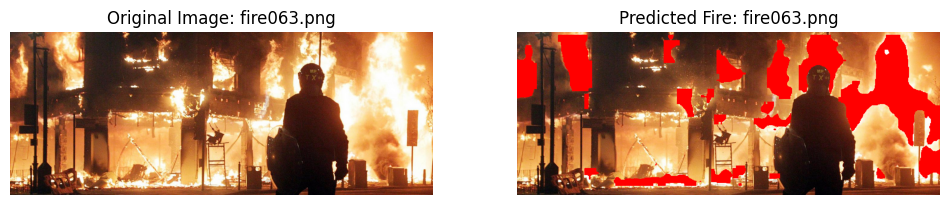

Processed and saved prediction for: fire063.png at /kaggle/working/predicted_outputs/prediction_fire063.png

image 1/1 /kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img/not_fire002.png: 352x640 (no detections), 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)
Prediction for not_fire002.png: 1 result(s) detected
No fire masks detected for: not_fire002.png


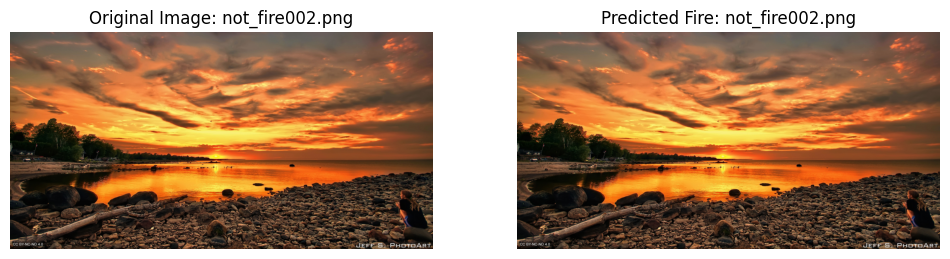

Processed and saved prediction for: not_fire002.png at /kaggle/working/predicted_outputs/prediction_not_fire002.png

image 1/1 /kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img/not_fire011.png: 448x640 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
Prediction for not_fire011.png: 1 result(s) detected
No fire masks detected for: not_fire011.png


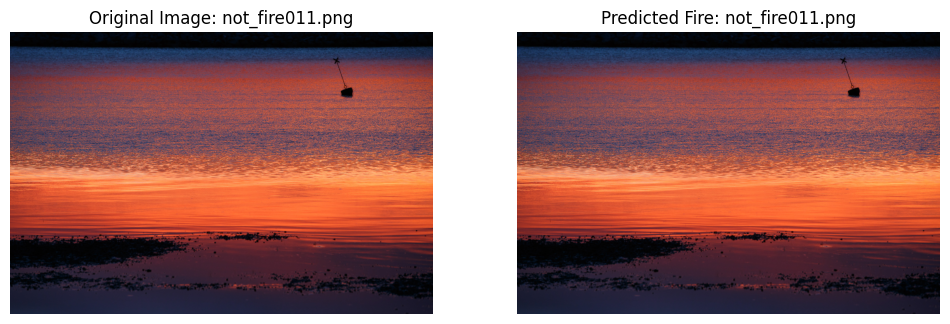

Processed and saved prediction for: not_fire011.png at /kaggle/working/predicted_outputs/prediction_not_fire011.png

image 1/1 /kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img/fire067.png: 640x448 5 fires, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)
Prediction for fire067.png: 1 result(s) detected


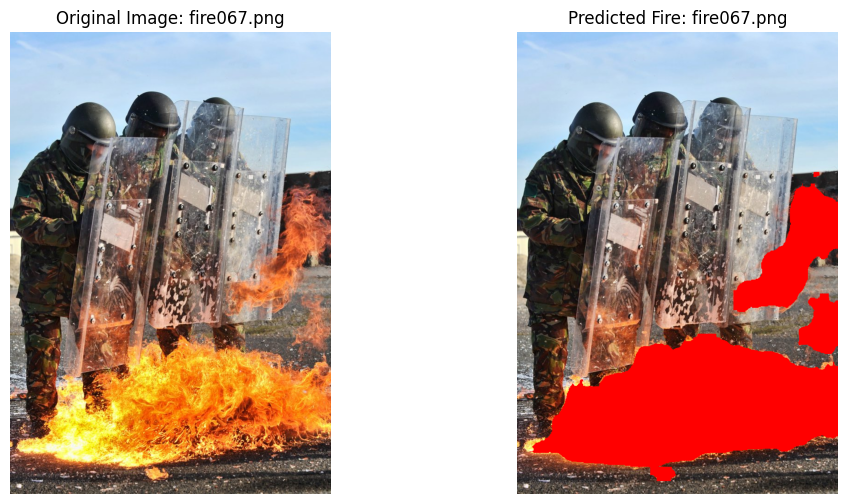

Processed and saved prediction for: fire067.png at /kaggle/working/predicted_outputs/prediction_fire067.png

image 1/1 /kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img/fire081.png: 448x640 1 fire, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)
Prediction for fire081.png: 1 result(s) detected


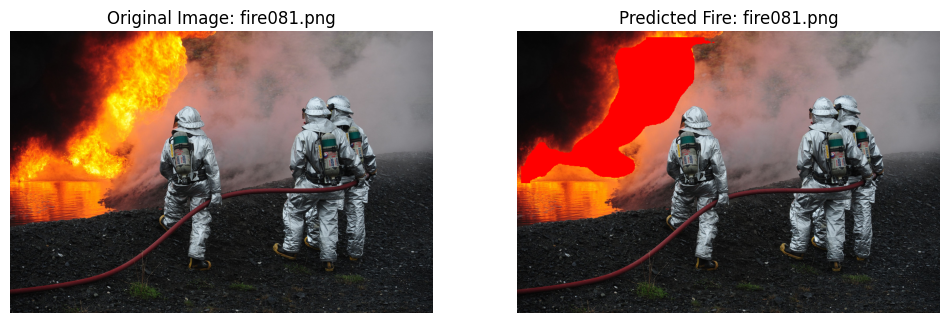

Processed and saved prediction for: fire081.png at /kaggle/working/predicted_outputs/prediction_fire081.png


In [14]:
# Load the trained model
model_path = "/kaggle/working/runs/segment/fire_segmentation/weights/best.pt"
if not os.path.exists(model_path):
    print(f"Model file not found at: {model_path}")
    raise FileNotFoundError(f"Model file missing: {model_path}")
model = YOLO(model_path)

# Directory containing test images
test_images_dir = "/kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img"
output_dir = "/kaggle/working/predicted_outputs"
os.makedirs(output_dir, exist_ok=True)

# Get list of test images (limit to 5 for demonstration, adjust as needed)
test_images = [f for f in os.listdir(test_images_dir) if f.endswith('.png')]
test_images = test_images[:5]  # Process first 5 images, modify this to process more
print(f"Found {len(test_images)} test images to process")

# Process and visualize multiple images
for idx, image_name in enumerate(test_images):
    # Load test image
    test_image_path = os.path.join(test_images_dir, image_name)
    img = cv2.imread(test_image_path)
    if img is None:
        print(f"Cannot read image: {test_image_path}")
        continue
    
    # Convert to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Predict with the model
    results = model.predict(test_image_path, conf=0.3)  # Confidence threshold of 0.3
    print(f"Prediction for {image_name}: {len(results)} result(s) detected")
    
    # Create a copy for drawing masks
    img_with_mask = img_rgb.copy()
    
    # Check and draw predicted masks
    mask_detected = False
    if results[0].masks is not None:
        mask_detected = True
        for mask in results[0].masks.data:
            mask = mask.cpu().numpy()  # Convert to numpy
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]))  # Resize to image size
            img_with_mask[mask > 0.5] = (255, 0, 0)  # Color fire regions red
    else:
        print(f"No fire masks detected for: {image_name}")
    
    # Create a figure for visualization
    plt.figure(figsize=(12, 6))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title(f"Original Image: {image_name}")
    plt.axis('off')
    
    # Plot image with predicted masks
    plt.subplot(1, 2, 2)
    plt.imshow(img_with_mask)
    plt.title(f"Predicted Fire: {image_name}")
    plt.axis('off')
    
    # Display the plot in the notebook
    plt.show()
    
    # Save the figure
    output_path = os.path.join(output_dir, f"prediction_{Path(image_name).stem}.png")
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    # Verify if the file was saved
    if os.path.exists(output_path):
        print(f"Processed and saved prediction for: {image_name} at {output_path}")
    else:
        print(f"Failed to save prediction for: {image_name} at {output_path}")